# Bias when Unconfoundedness is not Met
Julian Hsu
22 Dec 2023

The purpose of this script is to estimate the bias when we do not have enough control features to control for selection biases.

**sound byte**: A reminder that there is no substitute for having the correct information to identify the natural experiments in your non-experimental data. Outside of experiments, we want to rule out how other factors besides our "treatment" (ie, displayed ad) can influence our outcome. If one of these factors drives the treatment and outcome, then we have __selection bias__. In other words, we do not know whether customer conversion decreased because of our displayed ad, or because the displayed ad is only shown to customers who would have converted anyway.

With simulation evidence below (find the notebook here: notebook link), I show that when you do not have enough control features, you get plenty of selection bias in your estimate. The story is the same whether you use simple models (OLS) or more advanced causal models like double machine learning (DML-PLM).



In [1]:
import stnomics as st
import numpy as np
import pandas as pd
a
from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error


## DGP Generation

In [32]:
def data_gp(N=1000, te=1):
    x0 = np.random.normal(0,1,N)
    x1 = np.random.normal(0,1,N)
    x2 = np.random.normal(0,1,N)
    
    df = pd.DataFrame(data={'x0':x0, 'x1':x1, 'x2':x2})
    x_list = [e for e in df.columns if 'x' in e]
    
    
    ## Assign treatment status
    ## Make each feature substnatially significant, so don't let them center around zero
    random = np.random.uniform(0,1)
    if random > 0.5:
        latent_w = np.dot(df[x_list], np.random.uniform(2,3,3)) + np.random.normal(0,1,N)
    else:
        latent_w = np.dot(df[x_list], np.random.uniform(-3,-2,3)) + np.random.normal(0,1,N)
    latent_w = np.exp(latent_w) / (1 + np.exp(latent_w))
    df['w'] = (latent_w > np.percentile(latent_w, 50) ).astype(float)
    
    ## Assign outcome
    ## Make each feature substnatially significant, so don't let them center around zero
    random = np.random.uniform(0,1)
    if random > 0.5:
        df['y'] = np.dot(df[x_list], np.random.uniform(-3,-2,3)) + np.random.normal(0,1,N)
    else:
        df['y'] = np.dot(df[x_list], np.random.uniform(2,3,3)) + np.random.normal(0,1,N)

        
    df['y'] += df['w']*te
    
    return df

## Simulated Estimates
Look at OLS and two types of DML.

In [33]:
n_data_splits = 4
aux_dictionary = {'n_bins': 2, 'n_trees':2, 'max_depth':2, 
                  'upper':0.999, 'lower':0.001,
                  'bootstrapreps':1,
                  'subsample_ratio':0.5}


In [48]:
model_max_iter = 500
## treatment prediction models
t_models = {}
t_models['LogitCV'] = LogisticRegressionCV(cv=5, random_state=27, n_jobs=-1)
t_models['logit'] = LogisticRegression(penalty='l2',solver='lbfgs', C=1, max_iter=model_max_iter, fit_intercept=True)
t_models['logit_L1_C2'] = LogisticRegression(penalty='l1',C=2, max_iter=model_max_iter, fit_intercept=True)
t_models['logit_L2_C5'] = LogisticRegression(penalty='l2',C=2, max_iter=model_max_iter, fit_intercept=True)
t_models['rf_md10'] = RandomForestClassifier(n_estimators=250,max_depth=10, min_samples_split=200,n_jobs=-1)
t_models['rf_md3'] = RandomForestClassifier(n_estimators=250,max_depth=3, min_samples_split=200,n_jobs=-1)

## outcome prediction models
y_models = {}
y_models['LassoCV'] = LassoCV(cv=5, n_jobs=-1,  random_state=27)
y_models['ols'] = LinearRegression()
y_models['lasso_a2'] = Lasso(alpha=2,max_iter=model_max_iter)
y_models['ridge_a2'] = Ridge(alpha=2,max_iter=model_max_iter)
y_models['rf_md10'] = RandomForestRegressor(n_estimators=250,max_depth=10, min_samples_split=200,n_jobs=-1)
y_models['rf_md3'] = RandomForestRegressor(n_estimators=250,max_depth=3, min_samples_split=200,n_jobs=-1)


In [65]:
sim_range = 50
feature_list = ['x0','x1']
ols_x = []
plm_x = []
ols_y = []
plm_y = []


In [67]:
for s in range(sim_range):  
    df = data_gp(N=1000, te=1)
    ols = st.ate.ols_vanilla(df, 
                    'splits', feature_list, 'y', 'w',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    plm = st.ate.dml.dml_plm(df, 
                    'splits', feature_list, 'y', 'w',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )

    ols_x.append(ols['ATE TE'])
    plm_x.append(plm['ATE TE'])

    ols = st.ate.ols_vanilla(df, 
                    'splits', ['x0','x1','x2'], 'y', 'w',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    plm = st.ate.dml.dml_plm(df, 
                    'splits', ['x0','x1','x2'], 'y', 'w',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )

    ols_y.append(ols['ATE TE'])
    plm_y.append(plm['ATE TE'])
    
ols_x = np.array(ols_x)
plm_x = np.array(plm_x)

ols_y = np.array(ols_y)
plm_y = np.array(plm_y)


In [71]:
df_sim = pd.DataFrame(data={'gt':np.ones(len(ols_x))
                           , 'ols':ols_x
                           ,'dml-plm':plm_x
                           , 'ols_ideal':ols_y
                           ,'dml-plm_ideal':plm_y                            
                           })

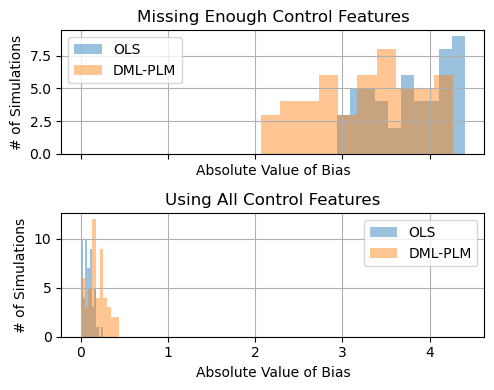

In [74]:
fig,ax = plt.subplots(ncols=1,nrows=2, sharex=True, sharey=False, figsize=(5,4))
ax[0].hist((df_sim['ols']-df_sim['gt']).abs(),     alpha=0.45, label='OLS')
ax[0].hist((df_sim['dml-plm']-df_sim['gt']).abs(), alpha=0.45, label='DML-PLM')
ax[0].legend()
ax[0].set_xlabel('Absolute Value of Bias')
ax[0].set_ylabel('# of Simulations')
ax[0].set_title('Missing Enough Control Features')
ax[0].grid()

ax[1].hist((df_sim['ols_ideal'] - df_sim['gt']).abs(),     alpha=0.45, label='OLS')
ax[1].hist((df_sim['dml-plm_ideal'] - df_sim['gt']).abs(), alpha=0.45, label='DML-PLM')
ax[1].legend()
ax[1].set_xlabel('Absolute Value of Bias')
ax[1].set_ylabel('# of Simulations')
ax[1].set_title('Using All Control Features')
ax[1].grid()

plt.tight_layout()
plt.show()


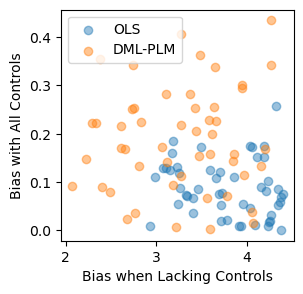

In [73]:
fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(3,3))
ax.scatter((df_sim['ols']-df_sim['gt']).abs()    , (df_sim['ols_ideal']-df_sim['gt']).abs(),     alpha=0.45, label='OLS')
ax.scatter((df_sim['dml-plm']-df_sim['gt']).abs(), (df_sim['dml-plm_ideal']-df_sim['gt']).abs(),     alpha=0.45, label='DML-PLM')
ax.legend()
ax.set_xlabel('Bias when Lacking Controls')
ax.set_ylabel('Bias with All Controls')

plt.show()

